# Time Series Forecasting using LSTMs 

## Objective 

- Students will understand how to prepare time series data for model ingestion (sliding train-test split) 
- Students will understand how to use a LSTM model for time series forecasting applications
- Students will understand the importance of seasonality and trends in time series applications.


### Applications of Time Series Forecasting 

![](https://miro.medium.com/max/2668/1*s7P8zInIavYbevpZg_iPaA.jpeg)


----
### Imports

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Activation, Dropout
import time #helper libraries
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

----
### Load Data
We'll work with a time series of energy usage and weather data from kaggle.
- Using the "Download" button at the top right of [this page](https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries), save the data zip archive file to your local machine.
- Extract the two `.csv` files from the zip archive. 
- Then upload the two `.csv` files  to your Colab notebook, by clicking the file folder icon, and then the file upload icon (file folder in portrait mode with upward arrow) on the left sidebar of the notebook.

In [3]:
def load_transform_data(weather_filepath, energy_filepath):
    """
    Load energy and weather data sets for energy consumption over a 4 year period for a single household in Austin, Texas. 
    Perform transformations in order to get data into a format that we can more easily use for LSTM modeling.
    
    Notes
    -----
    Links to source of data:
    https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=weather_2016_2020_daily.csv
    
    Parameters 
    ------
    None
    
    Returns
    -------
    df: pandas dataframe
        Contains both the energy and weather feature sets 
    """
    # load the energy data
    df_energy = pd.read_csv(energy_filepath, parse_dates=['StartDate'], index_col='StartDate')
    df_energy_day = df_energy.resample('D').sum()

    # # load the weather data
    df_weather = pd.read_csv(weather_filepath, parse_dates=['Date'], index_col='Date')

    # merge the two dataframes
    df = pd.merge(df_energy_day, df_weather, left_index=True, right_index=True)

    # cleanup
    df = df.drop(columns=['day_of_week_x', 'Day'])

    # rename column
    df = df.rename(columns={'Value (kWh)': 'kwh'})

    # truncate the dates (trim early and late dates)
    # to drop data that's only weekly
    df = df.loc["2016-06-01": '2020-01-01']

    return df

df = load_transform_data("weather_2016_2020_daily.csv", "power_usage_2016_to_2020.csv")

df.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y
2016-06-06,29.323,87,76.6,70,73,70.8,68,100,84.0,53,8,4.7,0,29.7,29.7,29.6,0.44,0
2016-06-07,43.361,95,87.0,82,79,74.4,69,89,67.6,44,15,9.9,6,29.9,29.9,29.8,0.00,1
2016-06-08,55.993,97,87.6,78,76,72.8,65,90,64.1,36,16,5.8,0,29.9,29.8,29.8,0.00,2
2016-06-09,39.040,92,83.2,75,76,73.8,70,97,75.0,48,16,7.0,0,30.0,30.0,29.9,0.02,3
2016-06-10,33.993,89,80.2,74,75,73.2,69,97,80.7,55,16,8.1,0,29.8,29.8,29.8,0.00,4


In [4]:
df.tail()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y
2019-12-28,5.200,77,69.6,63,68,65.0,61,97,85.9,66,22,10.1,3,29.8,29.7,29.6,0.00,5
2019-12-29,5.309,69,60.8,50,66,51.8,36,97,75.6,33,21,9.9,3,29.9,29.7,29.6,0.12,6
2019-12-30,4.947,61,50.3,39,37,31.0,26,89,51.8,26,10,5.7,0,30.1,30.0,29.9,0.71,0
2019-12-31,5.042,60,48.8,38,39,31.3,22,77,55.3,23,13,2.7,0,30.2,30.1,30.0,0.00,1
2020-01-01,4.814,60,55.0,48,58,46.3,35,93,73.8,47,18,7.3,0,30.0,29.8,29.7,0.00,2


----
### Explore data with some plots

####Daily kwh usage time series

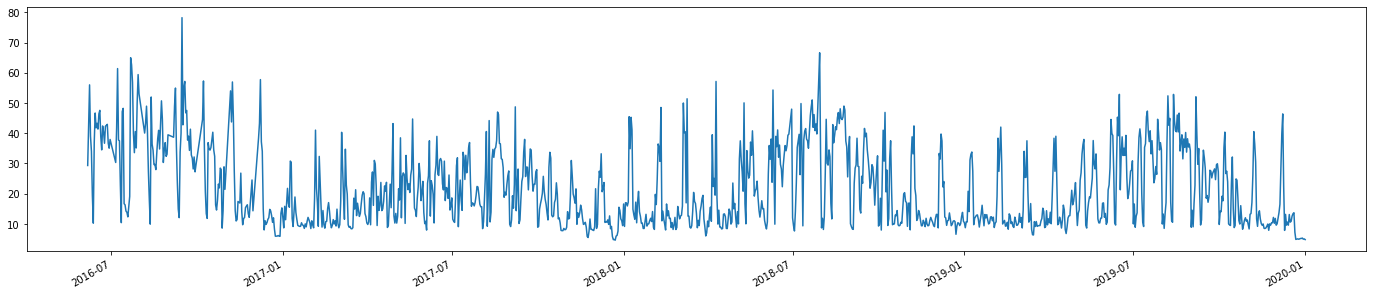

In [5]:
df.kwh.plot(figsize=(24,5));

####Daily Temperatures

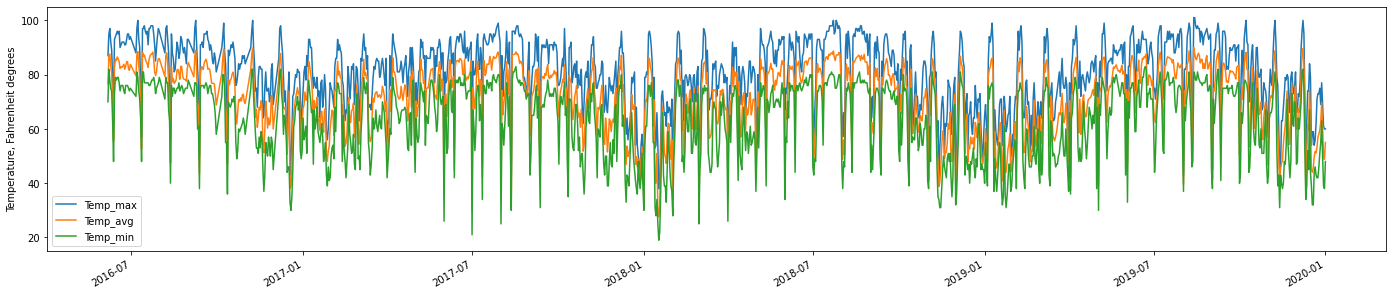

In [6]:
plot_cols = ["Temp_max", 'Temp_avg', 'Temp_min']
df[plot_cols].plot(figsize=(24,5))
plt.ylabel('Temperature, Fahrenheit degrees');

#### Power consumption by day of week

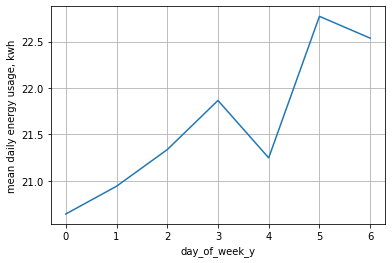

In [7]:
df.groupby(['day_of_week_y'])['kwh'].mean().plot()
plt.ylabel('mean daily energy usage, kwh')
plt.grid()

####Resample temperature data to monthly intervals

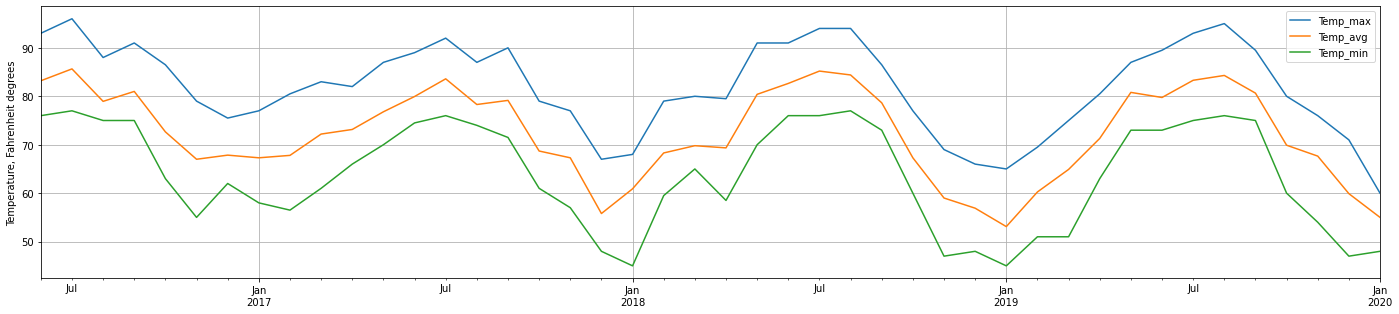

In [8]:
df[plot_cols].resample('M').median().plot(figsize=(24,5))
plt.ylabel('Temperature, Fahrenheit degrees')
plt.grid()

### Mean daily kwh consumption, by month

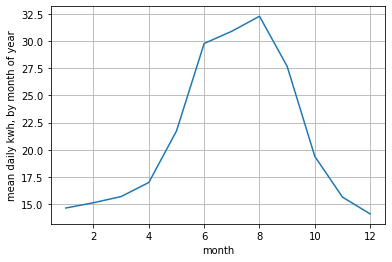

In [9]:
# help us capture seasonality
df['month'] = df.index.month
df.groupby(['month'])['kwh'].mean().plot()
plt.ylabel('mean daily kwh, by month of year')
plt.grid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


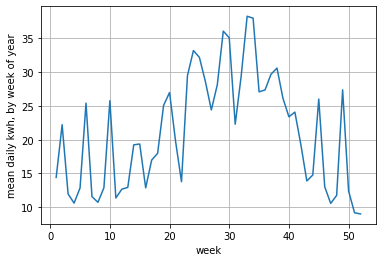

In [10]:
# help us capture seasonality
df['week'] = df.index.week
df.groupby(['week'])['kwh'].mean().plot()
plt.ylabel('mean daily kwh, by week of year');
plt.grid()

----
### Feature Selection
Identify features that are most strongly correlated with energy usage

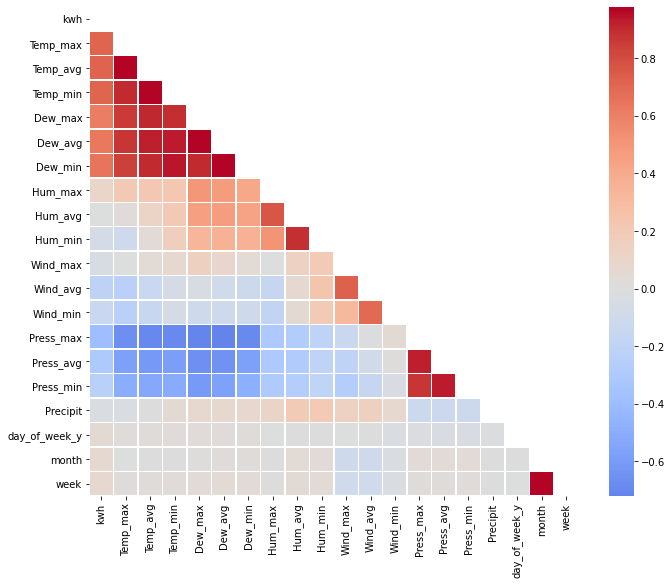

In [11]:
# correlation heat map

# correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11,9))

sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, linewidths=.5, square=True)

In [12]:
# Select which features you want to input into the model 
input_cols = ['Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Press_max', 'Press_avg', 'Press_min']
X = df[input_cols]

X.head()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Press_max,Press_avg,Press_min
2016-06-06,87,76.6,70,73,70.8,68,29.7,29.7,29.6
2016-06-07,95,87.0,82,79,74.4,69,29.9,29.9,29.8
2016-06-08,97,87.6,78,76,72.8,65,29.9,29.8,29.8
2016-06-09,92,83.2,75,76,73.8,70,30.0,30.0,29.9
2016-06-10,89,80.2,74,75,73.2,69,29.8,29.8,29.8


----
### Scale Data

In [13]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # use to save the column scaler functions
    scaler_dict = {} 
    
    # use to save the scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        col_scaled = scaler.fit_transform(feat)
        
        # save scaled column data to column key
        scaled_data[col] = col_scaled.flatten()
        
        # save scaler function to column key 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

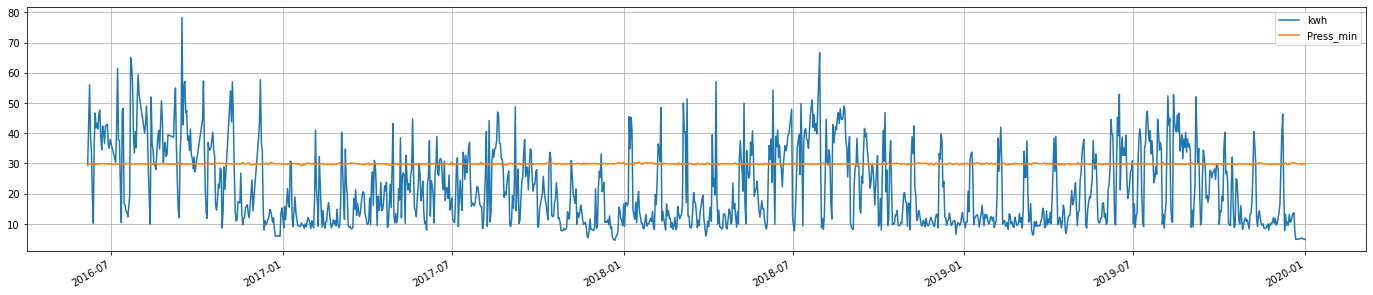

In [14]:
# plot non-scaled data
df.kwh.plot(figsize=(24,5), grid=True, legend=True);
df.Press_min.plot(figsize=(24,5), grid=True, legend=True);

In [15]:
# scale data 
df_scaled, scalers = scale_data(df)

df_scaled.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y,month,week
0,0.335705,0.791045,0.785256,0.796875,0.846154,0.864865,0.852941,1.00,0.767544,0.463415,0.060606,0.139013,0.000000,0.181818,0.250000,0.250000,0.032762,0.000000,0.454545,0.431373
1,0.526399,0.910448,0.951923,0.984375,0.938462,0.918919,0.867647,0.78,0.527778,0.353659,0.272727,0.372197,0.352941,0.363636,0.416667,0.416667,0.000000,0.166667,0.454545,0.431373
2,0.697993,0.940299,0.961538,0.921875,0.892308,0.894895,0.808824,0.80,0.476608,0.256098,0.303030,0.188341,0.000000,0.363636,0.333333,0.416667,0.000000,0.333333,0.454545,0.431373
3,0.467702,0.865672,0.891026,0.875000,0.892308,0.909910,0.882353,0.94,0.635965,0.402439,0.303030,0.242152,0.000000,0.454545,0.500000,0.500000,0.001489,0.500000,0.454545,0.431373
4,0.399143,0.820896,0.842949,0.859375,0.876923,0.900901,0.867647,0.94,0.719298,0.487805,0.303030,0.291480,0.000000,0.272727,0.333333,0.416667,0.000000,0.666667,0.454545,0.431373


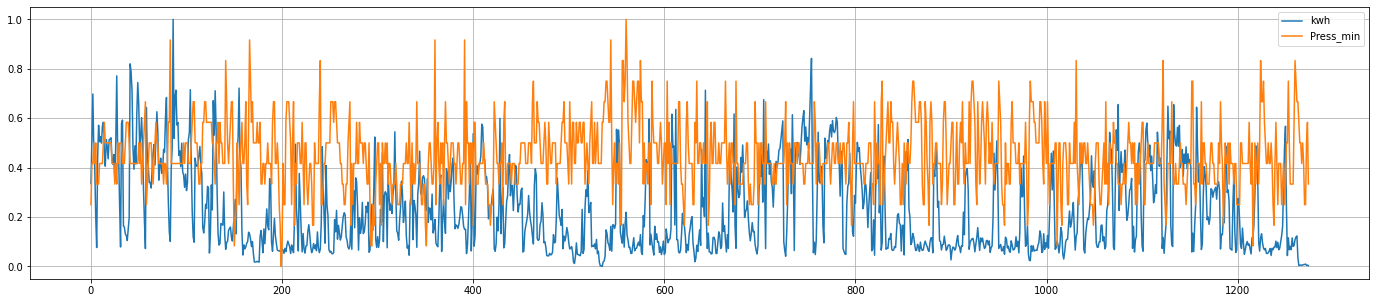

In [16]:
# plot scaled data

df_scaled.kwh.plot(figsize=(24,5), grid=True, legend=True);
# df_scaled.Temp_avg.plot(figsize=(24,5), grid=True, legend=True);
df_scaled.Press_min.plot(figsize=(24,5), grid=True, legend=True);

----
### Create Samples

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/11/Sliding-Window-Approach-to-Modeling-Time-Series.png)

### We'll create samples according to the following scheme
This is how you do cross-validation for time-series data

![](https://i.stack.imgur.com/fXZ6k.png )

In [45]:
def create_dataset(data, look_back=1, look_ahead=1):
    """
    Takes a 2D array of sequential data and creates (X) input and (Y) output sequences for timeseries forecasting.
    
    Parameters
    ---------
    data: 2D numpy array
        contains sequential data with n rows and m columns

    data is a dataframe whose first column is the targets
        
        If you provide more than a single input feature, make sure that the feature that is also used for the output
        is positioned in the 0 (zero) index column of the the array. Code below assumes this to be the case! 
        
        Example
        -------
        For the example data below, kWh column will be used as the output feature (i.e. what the model will be predicting).
        
                    kWh     Temp_avg
            0	0.335705	0.785256
            1	0.526399	0.951923
            2	0.697993	0.961538
            3	0.467702	0.891026
            4	0.399143	0.842949      
        
    look_back: int or float
        length of input sequence 
        
        I.E if look_behind = 1, then the input is a single value with index [t] (the present timestep)
            if look_behind = 2, then the input is a sequence of values with indices [t - 1, t]
            if look_behind = n, then the input is a sequence of values with indices [t - n, t - (n - 1), ... , t - 1, t]
            
    look_ahead: int or float
        number of steps into the future that we want to forecast
        
        I.E. if look_ahead = 1, then we want to forecast the value 1 timestep from now,  t + 1
             if look_ahead = 2, then we want to forecast the value 2 timesteps from now, t + 2
             if look_ahead = n, then we want to forecast the value n timesteps from now, t + n
    """
    # use to store new sequence samples 
    X_data, Y_data = [], []
    
    # number of original samples in dataset
    n_samples = len(data)
    
    # avoid an index error in the for loop by capping the max index value 
    # since we are using look_back & look_ahead number of samples for input and output sequences, respectively
    #   look_back and look_ahead both have to be >=1
    truncate = look_back + look_ahead 
    
    # number of new samples to create
    # we must subtract truncate from the number of new samples because the size of the look_back & look_ahead windows 
    n_new_samples = n_samples - (truncate + 1)
    
    # if user provided data with more than a single input feature
    # then index for the feature in the 0 index and use that as the output feature
    # get the targets
    if data.shape[1] > 1:
        y_data = data[:, 0]
        
    # if user provided a single feature dataset, leave data set as is 
    else:
        y_data = data

    # Now we drop the target (first column) from the data array
    data = data[:, 1:]
        
    # LOGIC FOR CREATING X AND Y 
    # we are going to create n_new_samples number of samples for our model 
    for i in range(n_new_samples):
        
        # create input sequence sample 
        x = data[i : i+look_back]
        
        # create output sequence sample 
        y = y_data[i+look_back : i + look_back + look_ahead ]
        y = y[-1] # y is actually a sequence, so we need to take the last value as our output (i.e. we are predicting a single value, not multiple)
        
        # append new samples to lists
        X_data.append(x)
        Y_data.append(y)
        
    return np.array(X_data), np.array(Y_data)

# create_dataset(df, look_back=7, look_ahead=1)

Let's create a small and simple dummy data set as input for `create_data` in order to see how the input and output data are structured. 

In [46]:
# create dummy array to test how function works
# note: the values here are completely arbitrary
# but using small, sequential integers helps us understanding the structuring of the sequences 
n = 11
dummy_data = np.arange(1, n)
dummy_data =dummy_data.reshape((dummy_data.shape[0], 1))
dummy_data


array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [50]:
X_data, Y_data = create_dataset(dummy_data, 
                                look_back=1, 
                                look_ahead=2
                               )

X_data

array([], shape=(6, 1, 0), dtype=int64)

In [52]:
X_data

array([], shape=(6, 1, 0), dtype=int64)

In [20]:
Y_data

array([[3],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [53]:
def create_train_test_split(df, look_back = 1, look_ahead = 1, train_size = 0.60):
    """
    Creates a train test split for sequential data used for time series forecasting. 
    """
    
    # calculate the number of training samples 
    n_samples = df.shape[0]
    train_size = int(n_samples * train_size)

    # samples between the zero and train_size indices are training samples 
    train = df.iloc[:train_size].values
    
    # samples between the train_size and the nth index are test samples 
    test = df.iloc[train_size:].values

    # create input and output splits 
    X_train, Y_train = create_dataset(train, look_back=look_back, look_ahead=look_ahead)
    X_test, Y_test = create_dataset(test, look_back=look_back, look_ahead=look_ahead)
    
    return X_train, Y_train, X_test, Y_test

In [54]:
df.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Press_max,Press_avg,Press_min
0,0.335705,0.791045,0.785256,0.796875,0.846154,0.864865,0.852941,0.181818,0.250000,0.250000
1,0.526399,0.910448,0.951923,0.984375,0.938462,0.918919,0.867647,0.363636,0.416667,0.416667
2,0.697993,0.940299,0.961538,0.921875,0.892308,0.894895,0.808824,0.363636,0.333333,0.416667
3,0.467702,0.865672,0.891026,0.875000,0.892308,0.909910,0.882353,0.454545,0.500000,0.500000
4,0.399143,0.820896,0.842949,0.859375,0.876923,0.900901,0.867647,0.272727,0.333333,0.416667


In [55]:
input_cols = ['kwh', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Press_max', 'Press_avg', 'Press_min']
df = df[input_cols]

df.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Press_max,Press_avg,Press_min
0,0.335705,0.791045,0.785256,0.796875,0.846154,0.864865,0.852941,0.181818,0.250000,0.250000
1,0.526399,0.910448,0.951923,0.984375,0.938462,0.918919,0.867647,0.363636,0.416667,0.416667
2,0.697993,0.940299,0.961538,0.921875,0.892308,0.894895,0.808824,0.363636,0.333333,0.416667
3,0.467702,0.865672,0.891026,0.875000,0.892308,0.909910,0.882353,0.454545,0.500000,0.500000
4,0.399143,0.820896,0.842949,0.859375,0.876923,0.900901,0.867647,0.272727,0.333333,0.416667


In [24]:
df_save = df
df = df_scaled[input_cols]

In [56]:
df

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Press_max,Press_avg,Press_min
0,0.335705,0.791045,0.785256,0.796875,0.846154,0.864865,0.852941,0.181818,0.250000,0.250000
1,0.526399,0.910448,0.951923,0.984375,0.938462,0.918919,0.867647,0.363636,0.416667,0.416667
2,0.697993,0.940299,0.961538,0.921875,0.892308,0.894895,0.808824,0.363636,0.333333,0.416667
3,0.467702,0.865672,0.891026,0.875000,0.892308,0.909910,0.882353,0.454545,0.500000,0.500000
4,0.399143,0.820896,0.842949,0.859375,0.876923,0.900901,0.867647,0.272727,0.333333,0.416667
...,...,...,...,...,...,...,...,...,...,...
1270,0.008015,0.641791,0.673077,0.687500,0.769231,0.777778,0.750000,0.272727,0.250000,0.250000
1271,0.009495,0.522388,0.532051,0.484375,0.738462,0.579580,0.382353,0.363636,0.250000,0.250000
1272,0.004578,0.402985,0.363782,0.312500,0.292308,0.267267,0.235294,0.545455,0.500000,0.500000
1273,0.005868,0.388060,0.339744,0.296875,0.323077,0.271772,0.176471,0.636364,0.583333,0.583333


In [112]:
# split data into X and Y train/test sets 
look_back = 14
look_ahead = 1

X_train, y_train, X_test, y_test = create_train_test_split(df, look_back, look_ahead, train_size=.6)

X_train.shape, y_train.shape

((749, 14, 9), (749,))

In [113]:
X_train[1,:,:]

array([[0.91044776, 0.95192308, 0.984375  , 0.93846154, 0.91891892,
        0.86764706, 0.36363636, 0.41666667, 0.41666667],
       [0.94029851, 0.96153846, 0.921875  , 0.89230769, 0.89489489,
        0.80882353, 0.36363636, 0.33333333, 0.41666667],
       [0.86567164, 0.89102564, 0.875     , 0.89230769, 0.90990991,
        0.88235294, 0.45454545, 0.5       , 0.5       ],
       [0.82089552, 0.84294872, 0.859375  , 0.87692308, 0.9009009 ,
        0.86764706, 0.27272727, 0.33333333, 0.41666667],
       [0.67164179, 0.69070513, 0.6875    , 0.76923077, 0.74474474,
        0.64705882, 0.54545455, 0.5       , 0.5       ],
       [0.52238806, 0.45032051, 0.453125  , 0.53846154, 0.55405405,
        0.52941176, 0.36363636, 0.33333333, 0.33333333],
       [0.88059701, 0.87980769, 0.84375   , 0.93846154, 0.92942943,
        0.91176471, 0.36363636, 0.33333333, 0.33333333],
       [0.89552239, 0.93108974, 0.9375    , 0.89230769, 0.92192192,
        0.92647059, 0.27272727, 0.33333333, 0.33333333],


In [27]:
.6*1275


765.0

----
### Create and compile model

In [114]:
# this model architecture is arbitrary - you can experiment with different architectures to see how it affects the score (i.e. gridsearch)
n_feats = len(input_cols) - 1
epochs = 25
batch_size = 32
dropout_prob = 0.5

input_shape = (look_back, n_feats)

# set learning rate and optimizer
opt = optimizers.Nadam(learning_rate=0.01)

# Create and train model here

model = Sequential()

# single LSTM layer
model.add(Bidirectional(LSTM(256, input_shape=input_shape, activation='tanh')))

#model.add(LSTM(256, input_shape=input_shape, activation='relu', return_sequences=False))
#model.add(LSTM(256, input_shape=input_shape, activation='tanh', return_sequences=False))

# model.add(LSTM(256, return_sequences=False, activation='tanh'))

# add dropout regularization
model.add(Dropout(dropout_prob))

# output layer WE'RE DOING REGRESSION, we want to predict one value
model.add(Dense(1, activation='relu'))

# compile model
# model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error', 'mean_absolute_error'])
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])

###Train model

In [115]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/25
24/24 [==============================] - 4s 37ms/step - loss: 2.5414 - mean_absolute_error: 0.5524 - val_loss: 0.0682 - val_mean_absolute_error: 0.2075
Epoch 2/25
24/24 [==============================] - 0s 9ms/step - loss: 0.0876 - mean_absolute_error: 0.2384 - val_loss: 0.0682 - val_mean_absolute_error: 0.2075
Epoch 3/25
24/24 [==============================] - 0s 10ms/step - loss: 0.0876 - mean_absolute_error: 0.2384 - val_loss: 0.0682 - val_mean_absolute_error: 0.2075
Epoch 4/25
24/24 [==============================] - 0s 10ms/step - loss: 0.0876 - mean_absolute_error: 0.2384 - val_loss: 0.0682 - val_mean_absolute_error: 0.2075
Epoch 5/25
24/24 [==============================] - 0s 11ms/step - loss: 0.0876 - mean_absolute_error: 0.2384 - val_loss: 0.0682 - val_mean_absolute_error: 0.2075
Epoch 6/25
24/24 [==============================] - 0s 12ms/step - loss: 0.0876 - mean_absolute_error: 0.2384 - val_loss: 0.0682 - val_mean_absolute_error: 0.2075
Epoch 7/25
24/24 [=====

In [30]:
np.sqrt(0.02)

0.1414213562373095

---
### Visualize model results

In [116]:
def plot_model_loss_metrics(history):
    """
    Use the model history callback to plot the train and test losses vs epochs as well as metrics vs. epochs 
    """
    
    # plot training and test loss scores 
    test_loss = history.history["val_loss"]
    train_loss = history.history["loss"]
    
    #test_mse = history.history["val_mean_squared_error"]
    #train_mse = history.history["mean_squared_error"]
    
    test_mae = history.history["val_mean_absolute_error"]
    train_mae = history.history["mean_absolute_error"]
    
    n_epochs = len(test_loss) + 1
    epochs = np.arange(1,  n_epochs)
    y_ticks = np.arange(0, 1, 11)

    plt.figure(figsize=(20,5))
    plt.title("Loss vs. Number of Epochs")
    plt.plot(epochs, test_loss, label = "Test Loss")
    plt.plot(epochs, train_loss, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epochs)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    # plt.figure(figsize=(20,5))
    # plt.title("mean_squared_error vs. Number of Epochs")
    # plt.plot(epochs, test_mse, label = "Test MSE")
    # plt.plot(epochs, train_mse, label = "Train MSE")
    # plt.xlim(1,20)
    # plt.xticks(epochs)
    # plt.grid()
    # plt.legend()
    # plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_absolute_error vs. Number of Epochs")
    plt.plot(epochs, test_mae, label = "Test MAE")
    plt.plot(epochs, train_mae, label = "Train MAE")
    plt.xlim(1,20)
    plt.xticks(epochs)
    plt.grid()
    plt.legend()
    plt.show() 

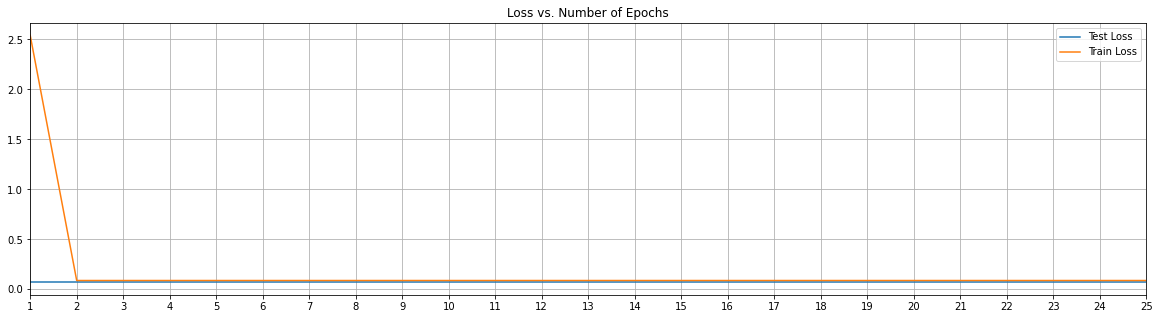

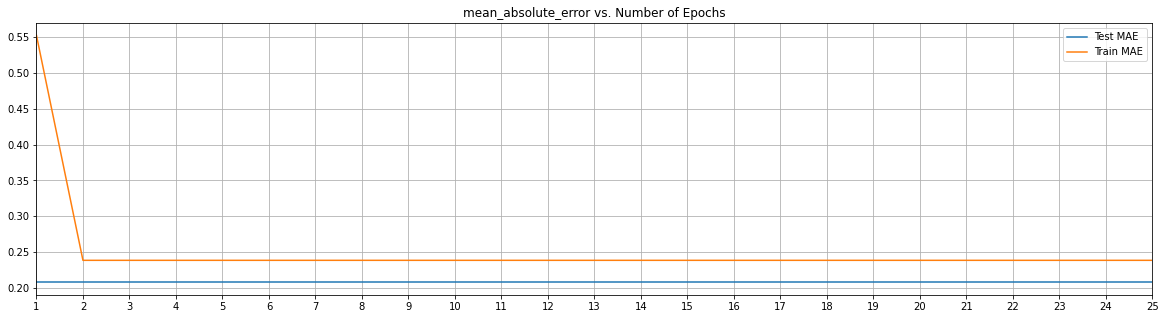

In [117]:
# plot model scores
plot_model_loss_metrics(history)

In [118]:
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    return y_train_predict, y_test_predict

In [104]:
# get predictions 

y_train_predict, y_test_predict = predict(X_train, X_test)

In [105]:
# Y_test and Y_train can be passed through this function only once
# predictions can be passed in here multiple times 
def inverse_scaling(data, scaler_dict, output_feat_name):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling so we have have the data in its original formate for interpretability. 
    """
    return scaler_dict[output_feat_name].inverse_transform(data)

In [106]:
# reshape Y_train and Y_test so number of rows appers first, i.e. (rows,cols)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)



In [107]:
# undo our normalization to plot our predictions in actual kwh
y_train_predict = inverse_scaling(y_train_predict, scalers, 'kwh')
y_test_predict = inverse_scaling(y_test_predict, scalers, 'kwh')

In [108]:
# perform inverse scaling of the data
y_train = inverse_scaling(y_train, scalers, 'kwh')
y_test = inverse_scaling(y_test, scalers, 'kwh')

----
### Plot Model Predictions

In [109]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict, label = "Predict", c="r")
    plt.plot(Y_train, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict, label = "Predict", c="r")
    plt.plot(Y_test, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

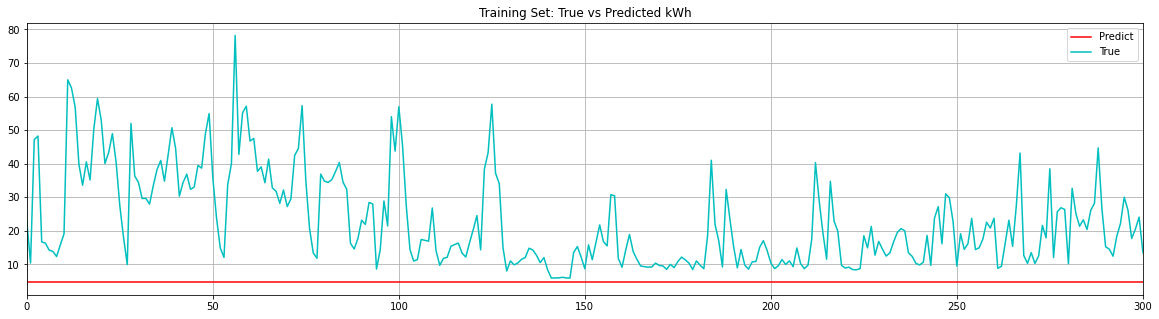

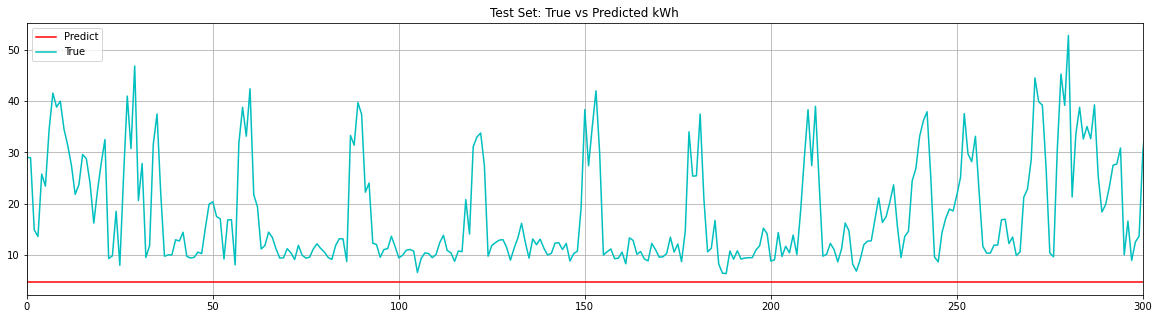

In [110]:
# plot model predictions 

plot_predictions(y_train, y_train_predict, y_test, y_test_predict)

-----
### Compare Model against a Baseline 

A naive model might predict that the power consumption tomorrow (or `n_lookahead` days from now) is the same as today's value. The error in this baseline model is the RMS difference between the time series of kWh with the time series of kWh shifted forward by n_lookahead days.

So then we can ask the question "can the model perform better than simply assuming that the power consumption tomorrow (or `n_lookahead` days from now) will be the same as it is today?"

Of course since `look_ahead` can be any value (not just 1) then the naive guess becomes "assume that the kWh consumption `n_lookahead` days from now will be the same as today."

Surprisingly, we find that a naive model predicting tomorrow's kWh usage will be the same as today's does slightly better than our LSTM model!

In [41]:
# use root mean squared error as metric for comparison 

# train_score
train_score = math.sqrt(mean_squared_error(y_train, y_train_predict))
print('Train Score: %.4f RMSE' % (train_score))

# test_score
test_score = math.sqrt(mean_squared_error(y_test, y_test_predict))
print('Test Score: %.4f RMSE' % (test_score))

# naive score with look_ahead = 1 day, i.e. assuming the consumption tomorrow will be the same as today
for n_look_ahead in range(0,5):
  y1 = [y_test[i][0] for i in range(0,len(y_test) - n_look_ahead)]
  y2 = [y_test[j][0] for j in range(n_look_ahead,len(y_test))]
  naive_score = math.sqrt(mean_squared_error(y1,y2))
  print(f'Naive baseline Score at lookahead {n_look_ahead} days is {naive_score:.4f} RMSE') 

Train Score: 10.7297 RMSE
Test Score: 9.0306 RMSE
Naive baseline Score at lookahead 0 days is 0.0000 RMSE
Naive baseline Score at lookahead 1 days is 8.0241 RMSE
Naive baseline Score at lookahead 2 days is 11.0591 RMSE
Naive baseline Score at lookahead 3 days is 13.1618 RMSE
Naive baseline Score at lookahead 4 days is 14.3584 RMSE
